In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure as fig
import skimage
from skimage import io, color
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku
from skimage import data, filters
from ipywidgets import widgets
from scipy.ndimage import convolve
from skimage import exposure
from skimage.filters import threshold_mean
import math

%matplotlib inline

    
def display_with_histogram(image, title):
    # pega parâmetros da imagem
    channels = image.shape[2] if len(image.shape) > 2 else 1
    is_colored = channels > 1

    # cria uma figura com espaço para a imagem e para o histograma
    figure, axes = plt.subplots(1, 2, figsize=(18, 5))
    image_axis, histogram_axis = axes

    # coloca a imagem em seu subplot
    image_axis.imshow(image, cmap='gray')
    image_axis.set_axis_off()
    image_axis.set_title('{} {}'.format(title, image.shape))

    # coloca o histograma em seu subplot
    if is_colored:
        channel_colors = ['red', 'green', 'blue']
        for i, c in enumerate(channel_colors):
            histogram_axis.hist(image[:, :, i].flatten(), bins=256, lw=1, color=c, histtype='step')
    else:
        histogram_axis.hist(image.ravel(), bins=256, lw=0, histtype='bar')
    histogram_axis.set_xlim(0, image.max())
    histogram_axis.set_yticks([])

    plt.show()


def display_all_images(images):
    # cria uma figura com espaço todas as imagens
    figure, axes = plt.subplots(2, 3, figsize=(18, 8))

    axes = axes.ravel()
    
    # coloca a imagem em seu subplot
    for i, image in enumerate(images):
        ax = axes[i]
        ax.imshow(image[1])
        ax.set_axis_off()
        ax.set_title(images[i][0])
        ax.plot()

    plt.show()
    

def display(title, image, full=False):
    size = (18,12) if full else (12,6)
    figure, axes = plt.subplots(num=1, figsize=size)
    axes.axis('off')
    axes.set_title('{} {}'.format(title, image.shape))
    axes.imshow(image)
    plt.show()
    
def display_two_images(left, right, title=''):
    figure, axes = plt.subplots(1, 2, figsize=size)
    left_ax, right_ax = axes

    left_ax.imshow(left)
    right_ax.imshow(right)
    
    left_ax.set_axis_off()
    right_ax.set_axis_off()
    
    plt.show()
    

def generate_tractor_beam(size, color_stops):
    # valor gaussiano de x
    def gaussian(x, a, b, c, d=0):
        return a * math.exp(-(x - b)**2 / (2 * c**2)) + d
    
    # cor do pixel j
    def pixel(j, length, map):
        length = float(length)
        r = sum([gaussian(j, p[1][0], p[0] * length, length/(len(map))) for p in map])
        g = sum([gaussian(j, p[1][1], p[0] * length, length/(len(map))) for p in map])
        b = sum([gaussian(j, p[1][2], p[0] * length, length/(len(map))) for p in map])
        a = sum([gaussian(j, p[1][3], p[0] * length, length/(len(map))) for p in map])
        return min(1.0, r), min(1.0, g), min(1.0, b), min(1.0, a)
    
    # abaula a imagem, tirando um semicírculo do alto e colocando-o
    # em baixo (usando transparência)
    def bulge_down(image, radius, distance):
        '''
        radius: raio do círculo
        distance: distância do centro do círculo até o topo
        '''
        circle_top_center = (-distance, image.shape[1]/2)
        circle_bottom_center = (image.shape[0]-radius, image.shape[1]/2)
        
        def distance_to_circle_center(i, j, center):
            return np.sqrt((i - center[0])**2 + (j - center[1])**2) 
        
        # cria arrays com as coordenadas i, j da imagem (para ser usado para mascarar)
        I, J = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing="ij")
        
        # aplica a máscara acima (fazendo um mini antialiasing)
        dist_from_center = distance_to_circle_center(I, J, circle_top_center)
        mask = dist_from_center <= radius*0.98
        image[mask, 3] = 0
        mask = (dist_from_center <= radius) & (dist_from_center > radius*0.98)
        image[mask, 3] = 0.1

        # aplica a máscara abaixo (antialiasing), fazendo com que os pixels
        # abaixo do círculo (fora dele) estejam transparentes
        dist_from_center = distance_to_circle_center(I, J, circle_bottom_center)
        mask = (dist_from_center > radius*0.98) & (I > circle_bottom_center[0])
        image[mask, 3] = 0.1
        mask = (dist_from_center > radius) & (I > circle_bottom_center[0])
        image[mask, 3] = 0
        
        return image
        
    # cria uma região de tamanho size com RGBA (tudo zero)
    region = np.zeros((size[0], size[1], 4), dtype="float")

    # define a cor de cada linha
    for j in range(region.shape[1]):
        region[:, j-1, :] = pixel(j, length=size[1], map=color_stops)

    # abaula o topo, tirando um pedaço circular
    bulge_circle_radius = region.shape[1]*1.5
    region = bulge_down(region, bulge_circle_radius, bulge_circle_radius - 10)
    
    return region

# tractor_beam = generate_tractor_beam((146,44), [
#     (0.0,    [0, 1, 0.931, 0]),       # azul transparente
#     (0.2,    [0, 1, 0.931, 0]),       # azul transparente
#     (0.3001, [0, 1, 0.917, 0.25]),     # azul ciano forte
#     (0.5,    [0.812, 1, 0.981, 0.15]), # quase branco
#     (0.6999, [0, 1, 0.917, 0.25]),
#     (0.7,    [0, 1, 0.931, 0]),
#     (1.0,    [0, 1, 0.931, 0])
# ])

# display('', tractor_beam)

## Imagens originais + procedural

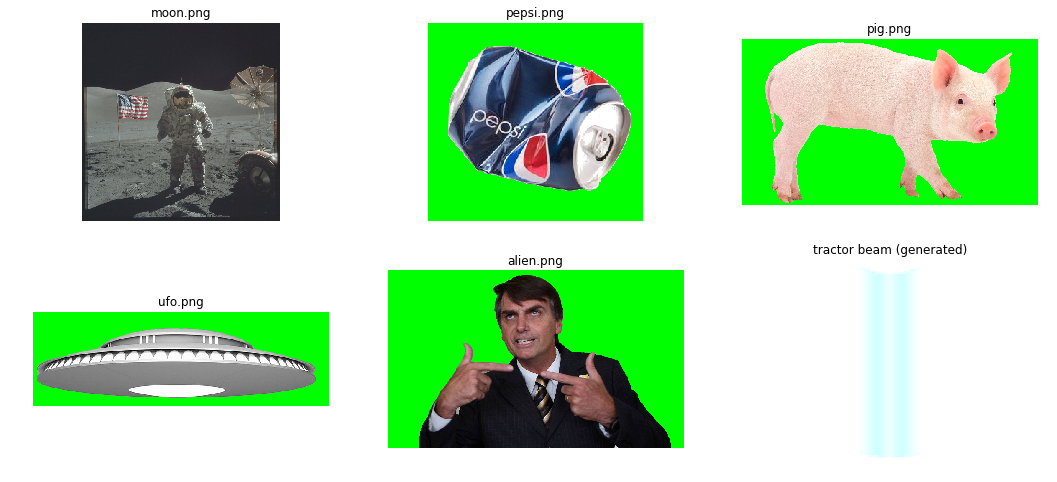

In [78]:
moon = skimage.img_as_float(io.imread("imagens/moon.png"))
pepsi = skimage.img_as_float(io.imread("imagens/pepsi.png"))
pig = skimage.img_as_float(io.imread("imagens/pig.png"))
ufo = skimage.img_as_float(io.imread("imagens/ufo.png"))
alien = skimage.img_as_float(io.imread("imagens/alien.png"))
tractor_beam = generate_tractor_beam((146,44), [
    (0.0,    [0, 1, 0.931, 0]),       # azul transparente
    (0.2,    [0, 1, 0.931, 0]),       # azul transparente
    (0.3001, [0, 1, 0.917, 0.15]),     # azul ciano forte
    (0.5,    [0.812, 1, 0.981, 0.275]), # quase branco
    (0.6999, [0, 1, 0.917, 0.15]),
    (0.7,    [0, 1, 0.931, 0]),
    (1.0,    [0, 1, 0.931, 0])
])

display_all_images([
    ('moon.png', moon), 
    ('pepsi.png', pepsi),
    ('pig.png', pig),
    ('ufo.png', ufo),
    ('alien.png', alien),
    ('tractor beam (generated)', tractor_beam)
])

## _Chroma keying_

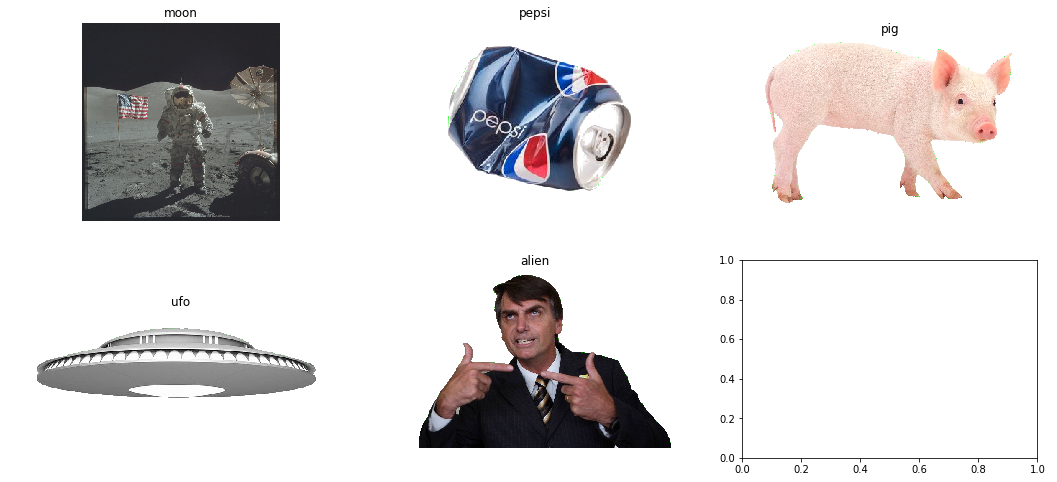

In [22]:
import numpy.ma as ma

def color_to_transparency(image, color, tolerance=0.25):
    '''
    Substitui uma cor da imagem RGBA por transparência.
    É utilizada uma tolerência de 25% em cada canal por padrão.
    '''
    masked_image = image.copy()
  
    reds = masked_image[:, :, 0]
    greens = masked_image[:, :, 1]
    blues = masked_image[:, :, 2]
    
    masked_reds = ma.masked_values(reds, color[0], atol=tolerance)
    masked_greens = ma.masked_values(greens, color[1], atol=tolerance)
    masked_blues = ma.masked_values(blues, color[2], atol=tolerance)
    masked_image[masked_reds.mask & masked_greens.mask & masked_blues.mask] = 0
    
    return masked_image



# tira o fundo das imagens
pepsi_transparent = color_to_transparency(pepsi, [0, 1, 0])
pig_transparent = color_to_transparency(pig, [0, 1, 0])
ufo_transparent = color_to_transparency(ufo, [0, 1, 0], tolerance=0.4)
alien_transparent = color_to_transparency(alien, [0, 1, 0])


# mostra o resultado
display_all_images([
    ('moon', moon),
    ('pepsi', pepsi_transparent),
    ('pig', pig_transparent),
    ('ufo', ufo_transparent),
    ('alien', alien_transparent),
])

## Mesclagem de imagens

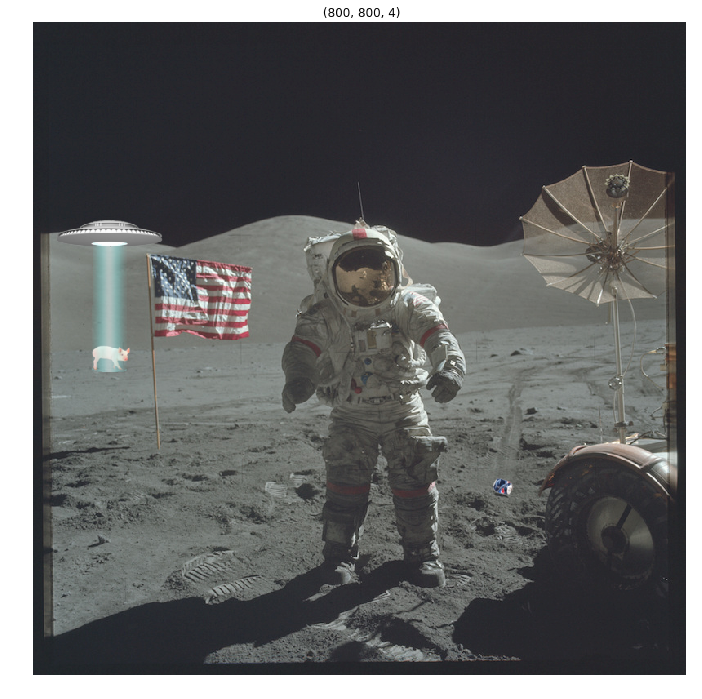

In [79]:
from skimage.transform import resize
from skimage import color

def merge_images(background, image, position=(0,0), scale=(1,1)):
    # pega as dimensões da imagem de fundo e da que será colada
    background_height, background_width, channels = background.shape
    image_height, image_width = np.floor(np.array(image.shape[:2]) * np.array(scale)).astype(int)
    
    # redimensiona a imagem para seu devido lugar
    image_resized = resize(image.copy(), (image_height, image_width), mode='constant', order=5, anti_aliasing=True, anti_aliasing_sigma=None, clip=True)
    
    # cria uma imagem do tamanho do background, mas com 0s
    new_image = np.zeros((background_height, background_width, channels))
    # cola a imagem no lugar
    y = position[0]
    x = position[1]
    new_image[y : y+image_height, x : x+image_width, :] = image_resized
    
    # cria máscara
    mask = np.stack([new_image[:, :, 3] for _ in range(4)], axis=2)
    inv_mask = 1 - mask
    
    # mesclagem final
    merged_image = background[:, :, :] * inv_mask + new_image * mask
    return np.clip(merged_image, 0, 1)

merged = merge_images(moon, pepsi_transparent, (556,561), (0.1, 0.1))
merged = merge_images(merged, ufo_transparent, (235,27), (0.2, 0.2))
merged = merge_images(merged, pig_transparent, (396,68), (0.035, 0.035))
merged = merge_images(merged, tractor_beam, (263, 72), (1.15, 1))
display('', merged, True)

/home/fegemo/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v
/home/fegemo/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/fegemo/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/home/fegemo/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


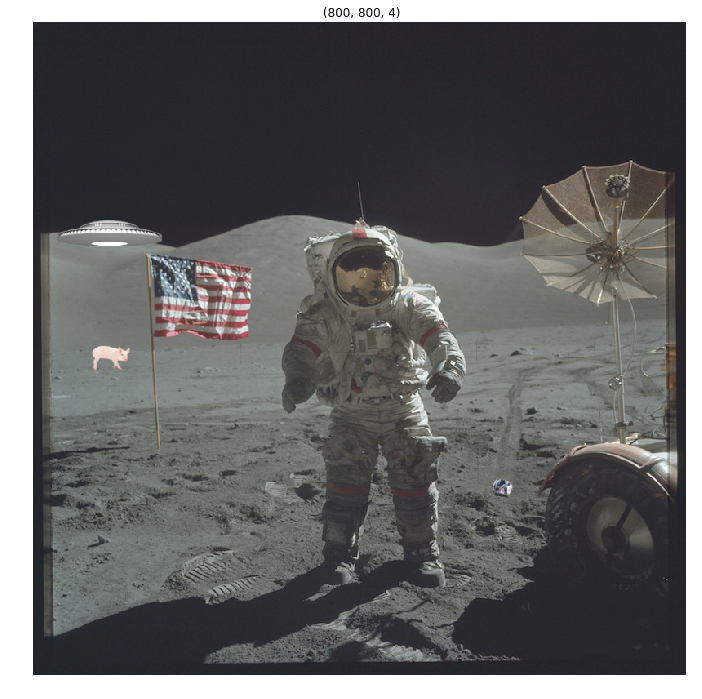

In [24]:
def desaturate(image, factor):
    only_rgb = image[:, :, :3]
    only_alpha = image[:, :, 3]
    
    # faz a dessaturação
    to_hsv = color.rgb2hsv(only_rgb)
    to_hsv[:, :, 1] *= factor

    # converte de volta para rgb, depois rgba
    only_rgb = color.hsv2rgb(to_hsv)
    back_to_rgba = np.dstack((only_rgb, np.zeros((image.shape[0], image.shape[1], 1))))
    empty_alpha = np.dstack((np.zeros((image.shape[0], image.shape[1], 3)), only_alpha))
    desaturated_image = empty_alpha + back_to_rgba
    
    return desaturated_image

pepsi_desaturated = desaturate(pepsi_transparent, 0.45)
ufo_desaturated = desaturate(ufo_transparent, 0.85)
pig_desaturated = desaturate(pig_transparent, 0.75)
merged = merge_images(moon, pepsi_desaturated, (556,561), (0.1, 0.1))
merged = merge_images(merged, ufo_desaturated, (235,27), (0.2, 0.2))
merged = merge_images(merged, pig_desaturated, (396,68), (0.035, 0.035))
display('', merged, True)

## Filtragem

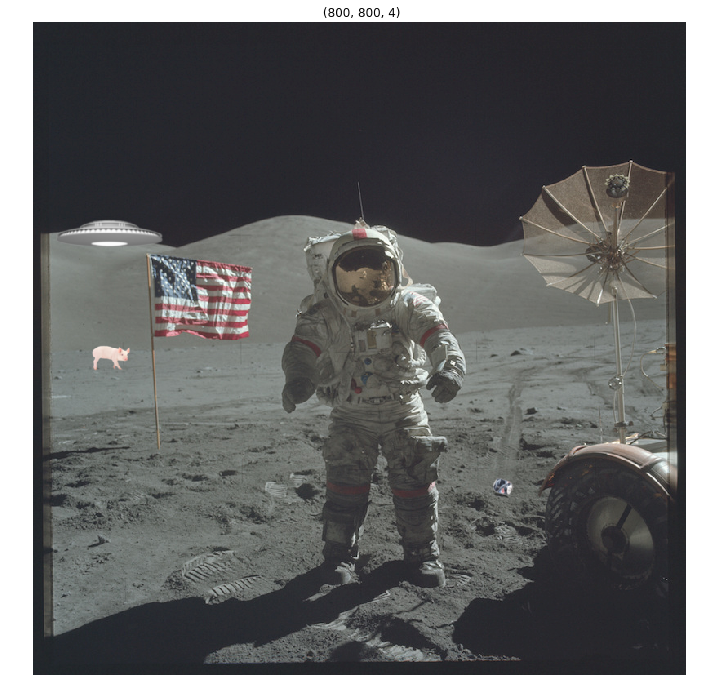

In [25]:
from skimage.filters import gaussian

def blur(image, amount=1):
    return gaussian(image, sigma=amount, multichannel=True)

pepsi_blurred = blur(pepsi_desaturated, 3)
ufo_blurred = blur(ufo_desaturated, 3)
merged = merge_images(moon, pepsi_blurred, (556,561), (0.1, 0.1))
merged = merge_images(merged, ufo_blurred, (235,27), (0.2, 0.2))
merged = merge_images(merged, pig_desaturated, (396,68), (0.035, 0.035))
display('', merged, True)